In [54]:
import pandas as pd
import numpy as np
from causalinference import CausalModel
import os, sys
sys.path.append(os.path.abspath("../../../"))
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

 ## Dataset importation ( Lalonde is a standard R dataset)

In [55]:
from rpy2.robjects import r as R

%load_ext rpy2.ipython
%R install.packages("Matching")
%R library(Matching)
%R data(lalonde)
%R -o lalonde
lalonde.to_csv("lalonde.csv",index=False)


(as ‘lib’ is unspecified)



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython








	‘/tmp/RtmpvYazc1/downloaded_packages’



In [56]:
lalonde=pd.read_csv("lalonde.csv")


## Data overview and preprocessing

In [57]:


lalonde.head()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [58]:
lalonde.describe()

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
count,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,25.370787,10.195506,0.833708,0.08764,0.168539,0.782022,2102.265533,1377.138638,5300.765138,0.732584,0.649438,0.415730
std,7.100282,1.792119,0.372762,0.28309,0.374766,0.413337,5363.583863,3150.961433,6631.493362,0.443109,0.477683,0.493402
min,17.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,9.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,10.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.810000,1.000000,1.000000,0.000000
75%,28.000000,11.000000,1.000000,0.00000,0.000000,1.000000,824.389000,1220.840000,8124.720000,1.000000,1.000000,1.000000
max,55.000000,16.000000,1.000000,1.00000,1.000000,1.000000,39570.700000,25142.200000,60307.900000,1.000000,1.000000,1.000000


In [59]:
lalonde.groupby('treat')['re78'].agg(['median','mean'])

,median,mean
treat,,
0,3138.795,4554.802283
1,4232.310,6349.145368


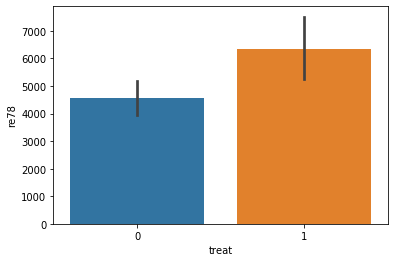

In [60]:
import seaborn as sns

sns.barplot(data=lalonde, x='treat', y='re78')



treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: re78, dtype: object

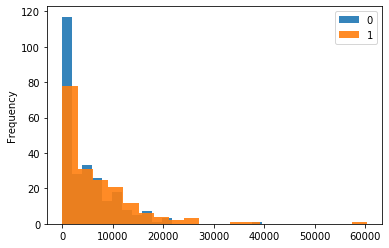

In [61]:
lalonde.groupby('treat')['re78'].plot(kind='hist', bins=20, alpha=0.9, legend=True)

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

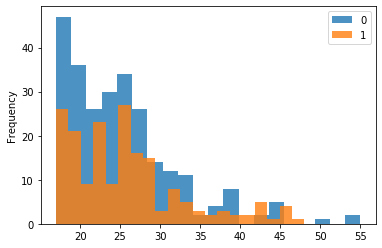

In [62]:


lalonde.groupby('treat')['age'].plot(kind='hist', bins=20, alpha=0.8, legend=True)



treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: educ, dtype: object

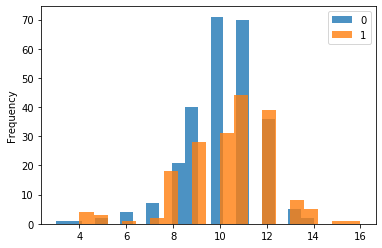

In [63]:


lalonde.groupby('treat')['educ'].plot(kind='hist', bins=20, alpha=0.8, legend=True)



## Naive estimate of ACE/ATE


In [64]:
(lalonde[lalonde['treat'] == 1].mean() - lalonde[lalonde['treat'] == 0].mean())['re78']



In [65]:


covariates = ['age', 'educ', 'black', 'married','re74', 're75']



## Using DoWhy

In [66]:
import dowhy.api



In [67]:
do_df = lalonde.causal.do(x='treat',
                          outcome='re78',
                          common_causes=['nodegr', 'black', 'hisp', 'age', 'educ', 'married'],
                          variable_types={'age': 'c', 'educ':'c', 'black': 'd', 'hisp': 'd',
                                          'married': 'd', 'nodegr': 'd','re78': 'c', 'treat': 'b'})

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treat'] on outcome ['re78']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


In [68]:
(do_df[do_df['treat'] == 1].mean() - do_df[do_df['treat'] == 0].mean())['re78']

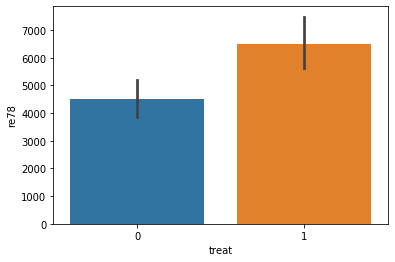

In [69]:


sns.barplot(data=do_df, x='treat', y='re78')




In [70]:
do_df = lalonde.causal.do(x={'treat': 1},
                          outcome='re78',
                          common_causes=['nodegr', 'black', 'hisp', 'age', 'educ', 'married'],
                          variable_types={'age': 'c', 'educ':'c', 'black': 'd', 'hisp': 'd',
                                          'married': 'd', 'nodegr': 'd','re78': 'c', 'treat': 'b'})

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treat'] on outcome ['re78']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


In [71]:
do_df.head()



,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat,propensity_score,weight
0,18,9,1,0,0,1,0.000,3287.38,5010.34,1,0,1,0.375014,2.666567
1,31,11,1,0,1,1,0.000,0.00,14509.90,1,1,1,0.421977,2.369796
2,17,10,1,0,0,1,0.000,0.00,0.00,1,1,1,0.361684,2.764845
3,18,9,1,0,0,1,0.000,3287.38,5010.34,1,0,1,0.375014,2.666567
4,21,8,1,0,0,1,989.268,3695.90,4279.61,0,0,1,0.391727,2.552797


## Using Causal Model

### Linear Model

In [72]:

causal = CausalModel(
    Y=lalonde['re78'].values, 
    D=lalonde['treat'].values, 
    X=lalonde[covariates].values)

causal.est_via_ols(adj=1)


print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1676.902    642.870      2.608      0.009    416.877   2936.927



/home/ahmed/anaconda3/lib/python3.7/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


### Matching Model

In [73]:
causal.est_propensity_s()

In [74]:
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      3.561      1.832      1.944      0.052     -0.030      7.152
            X1     -0.977      0.361     -2.705      0.007     -1.685     -0.269
            X0      0.003      0.014      0.211      0.833     -0.025      0.031
         X1*X1      0.056      0.019      2.950      0.003      0.019      0.093



In [75]:
causal.trim_s()

In [76]:

causal.stratify_s()

In [77]:


causal.est_via_matching(bias_adj=True)
print(causal.estimates)




Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1604.359   1071.583      1.497      0.134   -495.944   3704.661
           ATC   1383.124   1232.951      1.122      0.262  -1033.460   3799.709
           ATT   1916.973   1145.752      1.673      0.094   -328.702   4162.647



/home/ahmed/anaconda3/lib/python3.7/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef
